In [1]:
import nni
import numpy as np
import pandas as pd
import torch
import torch.utils.data as Data
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F
import matplotlib.pyplot as plt
import time 
from sklearn.metrics import r2_score

# import wandb ###You need to uncomment here to enable the wandb###
# wandb.init(project='2_port_network', entity='jiteng-ma')

In [2]:
###Import the data and randomly split them for training and testing###

total_data = pd.read_csv("three_port_coupler/FEM_1500.csv") ###This data file is the response of 1500MHz###
total_data = total_data.iloc[:, 2:]
total_data = total_data.dropna(axis=0,how='any') 
total_data = total_data.drop_duplicates()
train_data = total_data.sample(frac=0.8,axis=0,random_state=2)
test_data = pd.concat([total_data, train_data]).drop_duplicates(keep=False)

###Split the data into feature and label###

n_train = train_data.shape[0]
train_features = torch.tensor(train_data.iloc[:, 0:35].values, dtype=torch.float32)
test_features = torch.tensor(test_data.iloc[:, 0:35].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.iloc[:, 35:41].values, dtype=torch.float32)
test_labels  = torch.tensor(test_data.iloc[:, 35:41].values, dtype=torch.float32)

In [3]:
torch_traindata = Data.TensorDataset(train_features, train_labels)
torch_testdata = Data.TensorDataset(test_features, test_labels)
BATCH_SIZE = 128

train_dataloader = Data.DataLoader(
    dataset = torch_traindata,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 2,
)

test_dataloader = Data.DataLoader(
    dataset = torch_testdata,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 2,
)

params = {
    'features': 128,
    'lr': 0.0012743437430190571,
}

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(35, params['features']),
            nn.ReLU(),
            nn.Linear(params['features'], params['features']),
            nn.ReLU(),
            nn.Linear(params['features'], 6)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

Using cuda device


In [5]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            R2_value = r2_score(pred.to("cpu"),y.to("cpu"))
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
#     correct /= size
    return test_loss, R2_value

In [6]:
epochs = 100
test_accuracy = []
train_accuracy = []
R2_accuracy = []
time1 = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_accuracy.append(train_loss)
    accuracy, R2_value = test(test_dataloader, model, loss_fn)
    nni.report_intermediate_result(accuracy)
    test_accuracy.append(accuracy)
    R2_accuracy.append(R2_value)
    print(f'Epoch: {t:02d}, Trainloss: {train_loss:.6f}, TestR2: {R2_value:.4f}')
time2 = time.time()
nni.report_final_result(accuracy)


Epoch 1
-------------------------------
[2024-04-01 13:03:08] Intermediate result: 0.013151866206455799  (Index 0)
Epoch: 00, Trainloss: 0.013453, TestR2: 0.0889
Epoch 2
-------------------------------
[2024-04-01 13:03:09] Intermediate result: 0.008469116955345113  (Index 1)
Epoch: 01, Trainloss: 0.009455, TestR2: 0.3842
Epoch 3
-------------------------------
[2024-04-01 13:03:10] Intermediate result: 0.0062816985661075225  (Index 2)
Epoch: 02, Trainloss: 0.006942, TestR2: 0.4729
Epoch 4
-------------------------------
[2024-04-01 13:03:11] Intermediate result: 0.005156610482594087  (Index 3)
Epoch: 03, Trainloss: 0.005836, TestR2: 0.5414
Epoch 5
-------------------------------
[2024-04-01 13:03:11] Intermediate result: 0.004511692058590669  (Index 4)
Epoch: 04, Trainloss: 0.005013, TestR2: 0.5932
Epoch 6
-------------------------------
[2024-04-01 13:03:12] Intermediate result: 0.004060230857234389  (Index 5)
Epoch: 05, Trainloss: 0.004418, TestR2: 0.6214
Epoch 7
-------------------

In [7]:
print("The training time:", round(time2-time1, 2), "s")

The training time: 86.23 s


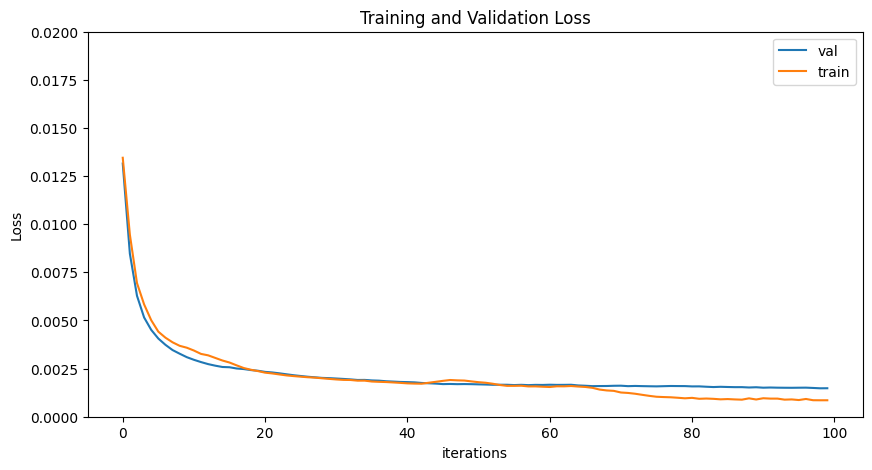

In [8]:
plt.figure(figsize=(10,5))
plt.ylim((0, 0.02))
train_accuracy = torch.tensor(train_accuracy, device = 'cpu')
plt.title("Training and Validation Loss")
plt.plot(test_accuracy,label="val")
plt.plot(train_accuracy,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [9]:
R2 = pd.DataFrame(R2_accuracy)
R2.to_csv('MLP_CNN_R2.csv')

In [10]:
max(R2_accuracy)

0.8691098392653788

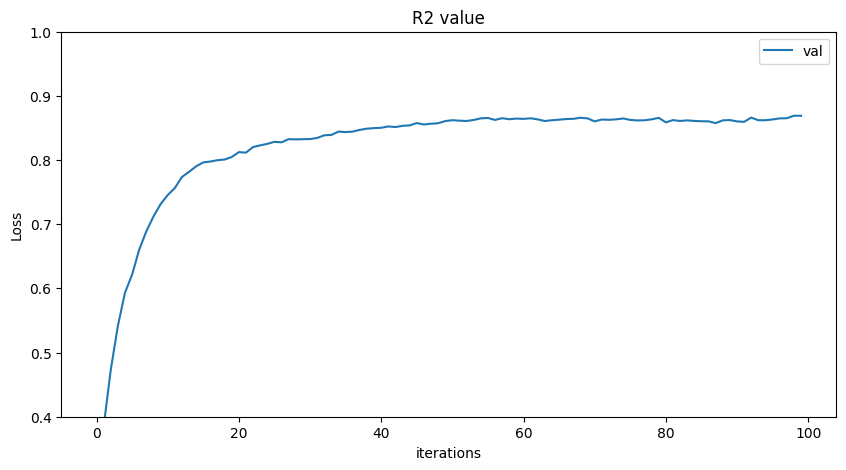

In [11]:
plt.figure(figsize=(10,5))
plt.ylim((0.4, 1))
R2_accuracy = torch.tensor(R2_accuracy, device = 'cpu')
plt.title("R2 value")
plt.plot(R2_accuracy,label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

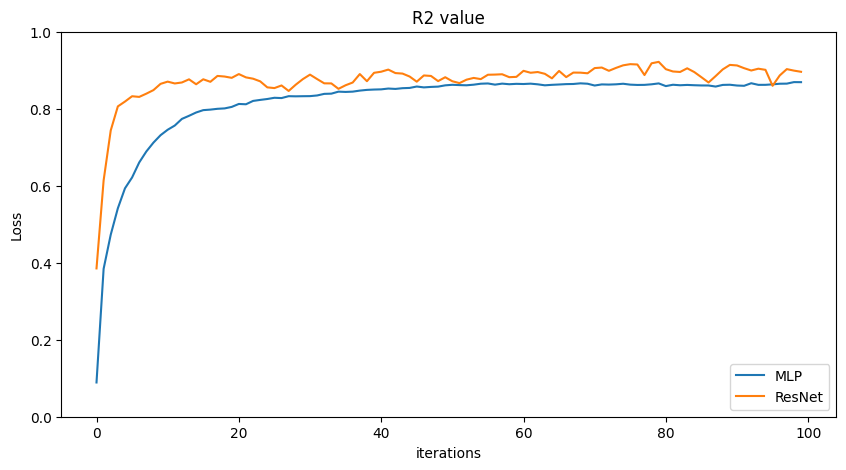

In [12]:
R2_MLP = pd.read_csv('MLP_CNN_R2.csv')
R2_ResNet = pd.read_csv('ResNet_CNN_R2.csv')

plt.figure(figsize=(10,5))
plt.ylim((0, 1))
R2_MLP = torch.tensor(R2_MLP["0"].values, device = 'cpu')
R2_ResNet = torch.tensor(R2_ResNet["0"].values, device = 'cpu')
plt.title("R2 value")
plt.plot(R2_MLP,label="MLP")
plt.plot(R2_ResNet,label="ResNet")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
import torchsummary
torchsummary.summary(model.cuda(0), (1, 35))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [-1, 35]               0
            Linear-2                  [-1, 128]           4,608
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                    [-1, 6]             774
Total params: 21,894
Trainable params: 21,894
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


In [14]:
def getModelSize(model):
    param_size = 0
    param_sum = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
        param_sum += param.nelement()
    buffer_size = 0
    buffer_sum = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        buffer_sum += buffer.nelement()
    all_size = (param_size + buffer_size) / 1024
    print('The model size is：{:.3f}KB'.format(all_size))
    return (param_size, param_sum, buffer_size, buffer_sum, all_size)
    
a, b, c, d, e = getModelSize(model)

The model size is：85.523KB
